In [1]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier,GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV,train_test_split,PredefinedSplit

from imblearn.under_sampling import ClusterCentroids

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np

import string

In [2]:
np.random.seed(42)

In [3]:
#Read train dataset
insurance_data=pd.read_csv('./train.csv')

In [4]:
insurance_data.describe()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
count,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,5.265666e+06,3.415164e+06,1.869133,2006.118667,1999.505933,-0.006781,-0.063997,-0.025057,-0.053640,0.012070,-0.044910,-0.024929,-0.064832,0.032385,0.071626,0.078748,0.041319,54.862481
std,3.034083e+06,1.942246e+06,1.150848,0.804947,5.048889,0.976902,0.960495,1.016570,0.959304,0.986830,0.971651,1.000754,0.979235,1.063700,1.148950,1.144502,1.073275,244.230985
min,1.160000e+03,6.830000e+02,1.000000,2005.000000,1981.000000,-2.578222,-2.441519,-2.744055,-2.457475,-3.350344,-2.300626,-2.262411,-1.882994,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
25%,2.670346e+06,1.917093e+06,1.000000,2005.000000,1997.000000,-0.665897,-0.816152,-0.869687,-0.783019,-0.662235,-0.688765,-0.898486,-0.646298,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
50%,5.255290e+06,3.654160e+06,2.000000,2006.000000,2000.000000,-0.320393,-0.124506,-0.221758,-0.106471,-0.115098,-0.241936,-0.468419,-0.269656,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
75%,7.858568e+06,4.992703e+06,2.000000,2007.000000,2003.000000,0.442930,0.480684,0.726996,0.485509,0.550982,0.500830,0.870931,0.327962,-0.231530,-0.266117,-0.272337,-0.251419,5.905322
max,1.051789e+07,6.484624e+06,17.000000,2007.000000,2008.000000,4.540768,6.307799,5.563325,6.100857,3.869488,4.584289,4.127148,33.457737,6.627110,8.883081,8.691144,6.388802,11440.750000


In [5]:
# Display frequency counts of values in 'Claim Amounts'
insurance_data.Claim_Amount.value_counts()

0.00000      21000
35.95240         2
36.90490         2
143.28640        2
32.29789         2
             ...  
129.48490        1
255.52600        1
48.25171         1
565.83620        1
39.52774         1
Name: Claim_Amount, Length: 8997, dtype: int64

array([[<AxesSubplot:title={'center':'Claim_Amount'}>]], dtype=object)

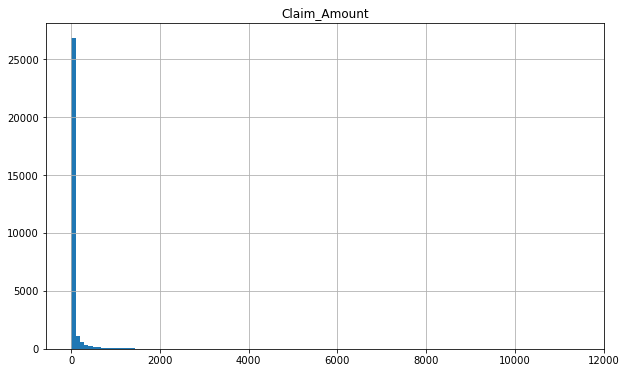

In [6]:
insurance_data.hist(column=['Claim_Amount'],bins=120,figsize=(10,6))

In [7]:
#It is observed that majority of the values are 0 claims
#Various regressor models will be compared to find the best working model

#Due to the large number of 0 claims, a tandem model will also be created/ tested by combining a binary classifier
#to sort out the 0 and non 0 claims, and a regressor to predict the non zero claim values

In [8]:
#Creating a copy of the original dataset as a backup and work on it
insurance_data_copy=insurance_data.copy()

In [9]:
#Creating an extra column for identifying 0 and non 0 claims

#Stratifier = 0 for 0 claims and 1 for non 0 Claims
insurance_data_copy['Stratifier']=insurance_data_copy['Claim_Amount'].apply(lambda claim: claim if claim==0 else 1)

#splitting training and test data
original_train_set,original_test_set= train_test_split(insurance_data_copy,test_size=0.15,random_state=42)

#Splitting train_2 and validation set proportionally
train_set,validation_set=train_test_split(original_train_set,test_size=0.15,random_state=42)

In [10]:
#Finding out the useful features among the categorical features

#Looping through all categorical columns to find the number of unique values and missing values

missing=[]
unique=[]
col_names=[]

for col in train_set.select_dtypes(exclude=['float64','int64']).columns:
    values=set(train_set[col].values)
    #only type of missing values are '?'
    if "?" in values or "" in values:
        missing.append((train_set[col]=='?').sum())
    else:
        missing.append(0)
        
    col_names.append(col)
    unique.append(len(train_set[col].value_counts()))

df_miss_uni=pd.DataFrame({'Unique':unique,'Missing':missing},index=col_names)
df_miss_uni.sort_values('Unique',ascending=False)

,Unique,Missing
Blind_Submodel,1489,12
Blind_Model,787,12
Blind_Make,58,12
NVCat,15,0
Cat1,11,33
OrdCat,8,18
Cat3,7,7
Cat11,7,41
Cat12,6,0
Cat6,6,33


In [11]:
#We choose the categorical features that provide us with the most information (unique values), least missing values 
#and does not significantly increase our feature space (while Encoding)

#From the above table, we choose the features Blind_Make,Blind_Model,Blind_Submodel,NVCat and OrdCat 
#(OrdCat is an ordinal variable ordered on integers)

#In order to use the features Blind_Make,Blind_Model and Blind_Submodel with large number of unique values, 
#we do not use OneHotEncoder on them, we need to find an alternative approach

In [12]:
#From the above table we see that Blind_Make, Blind_Model and Blind_Submodel have missing values, let's review them

In [13]:
train_set[train_set['Blind_Make']=='?']

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount,Stratifier
21430,2959699,2063141,1,2006,2004,?,?,?,F,C,...,0.498491,-0.972211,2.337415,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
6606,4906216,3108586,1,2005,2002,?,?,?,A,C,...,-0.082855,-0.677309,1.429994,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
23203,2668985,1916604,1,2005,2003,?,?,?,F,C,...,0.059850,-0.972211,2.106594,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
17886,8092873,5153020,1,2005,2003,?,?,?,B,C,...,-0.211523,-0.800185,0.613370,N,2.054683,-0.266117,-0.272337,-0.251419,5.748932,1.0
12305,8017601,5126989,1,2007,2002,?,?,?,A,C,...,0.188518,-0.677309,1.558532,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
20116,4160788,2608193,1,2007,2004,?,?,?,B,C,...,-0.391659,-0.800185,0.494131,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
19932,8869889,5803719,2,2006,2003,?,?,?,B,C,...,-0.211523,-0.800185,0.613370,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
18735,4055236,2573687,1,2005,2002,?,?,?,B,C,...,-0.211523,-0.800185,0.598602,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
16665,1652478,939349,2,2007,2002,?,?,?,B,C,...,-0.211523,-0.800185,0.598602,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
20602,3706292,2448524,1,2005,2002,?,?,?,A,C,...,0.188518,-0.677309,1.558532,N,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0


In [14]:
train_set[train_set['Blind_Model']=='?']

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount,Stratifier
21430,2959699,2063141,1,2006,2004,?,?,?,F,C,...,0.498491,-0.972211,2.337415,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
6606,4906216,3108586,1,2005,2002,?,?,?,A,C,...,-0.082855,-0.677309,1.429994,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
23203,2668985,1916604,1,2005,2003,?,?,?,F,C,...,0.059850,-0.972211,2.106594,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
17886,8092873,5153020,1,2005,2003,?,?,?,B,C,...,-0.211523,-0.800185,0.613370,N,2.054683,-0.266117,-0.272337,-0.251419,5.748932,1.0
12305,8017601,5126989,1,2007,2002,?,?,?,A,C,...,0.188518,-0.677309,1.558532,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
20116,4160788,2608193,1,2007,2004,?,?,?,B,C,...,-0.391659,-0.800185,0.494131,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
19932,8869889,5803719,2,2006,2003,?,?,?,B,C,...,-0.211523,-0.800185,0.613370,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
18735,4055236,2573687,1,2005,2002,?,?,?,B,C,...,-0.211523,-0.800185,0.598602,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
16665,1652478,939349,2,2007,2002,?,?,?,B,C,...,-0.211523,-0.800185,0.598602,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
20602,3706292,2448524,1,2005,2002,?,?,?,A,C,...,0.188518,-0.677309,1.558532,N,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0


In [15]:
train_set[train_set['Blind_Submodel']=='?']

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount,Stratifier
21430,2959699,2063141,1,2006,2004,?,?,?,F,C,...,0.498491,-0.972211,2.337415,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
6606,4906216,3108586,1,2005,2002,?,?,?,A,C,...,-0.082855,-0.677309,1.429994,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
23203,2668985,1916604,1,2005,2003,?,?,?,F,C,...,0.059850,-0.972211,2.106594,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
17886,8092873,5153020,1,2005,2003,?,?,?,B,C,...,-0.211523,-0.800185,0.613370,N,2.054683,-0.266117,-0.272337,-0.251419,5.748932,1.0
12305,8017601,5126989,1,2007,2002,?,?,?,A,C,...,0.188518,-0.677309,1.558532,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
20116,4160788,2608193,1,2007,2004,?,?,?,B,C,...,-0.391659,-0.800185,0.494131,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
19932,8869889,5803719,2,2006,2003,?,?,?,B,C,...,-0.211523,-0.800185,0.613370,O,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
18735,4055236,2573687,1,2005,2002,?,?,?,B,C,...,-0.211523,-0.800185,0.598602,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
16665,1652478,939349,2,2007,2002,?,?,?,B,C,...,-0.211523,-0.800185,0.598602,M,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0
20602,3706292,2448524,1,2005,2002,?,?,?,A,C,...,0.188518,-0.677309,1.558532,N,-0.231530,-0.266117,-0.272337,-0.251419,0.000000,0.0


In [16]:
#Blind_Make, Blind_Model and Blind_Submodel all have the same missing values, we can drop these rows since they have multiple
#missing values on our feature space. This will be dealt using the categorical_transformer function later.

In [17]:
#Blind Make contains A,…,Z,AA,…,AZ,BA,…,BZ,… as per the data_dictionary file 
#Creating dictionary to convert Blind Make to Integer (LabelEncoding)

alpha=list(string.ascii_uppercase)
#Creating a list of single letter's (A,...,Z)
ordinal_vals=alpha.copy()
for letter_1 in alpha:
    for letter_2 in alpha:
        #Appending all possible 2 letter combinations of Blind Make values (AZ,BA,…,BZ,… )
        ordinal_vals.append(letter_1+letter_2)
        
#Dictionary mapping Blind Make to integer values        
ordinal_vals=dict(zip(ordinal_vals,list(range(1,len(ordinal_vals)+1))))

ordinal_vals

{'A': 1,
 'B': 2,
 'C': 3,
 'D': 4,
 'E': 5,
 'F': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'J': 10,
 'K': 11,
 'L': 12,
 'M': 13,
 'N': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'T': 20,
 'U': 21,
 'V': 22,
 'W': 23,
 'X': 24,
 'Y': 25,
 'Z': 26,
 'AA': 27,
 'AB': 28,
 'AC': 29,
 'AD': 30,
 'AE': 31,
 'AF': 32,
 'AG': 33,
 'AH': 34,
 'AI': 35,
 'AJ': 36,
 'AK': 37,
 'AL': 38,
 'AM': 39,
 'AN': 40,
 'AO': 41,
 'AP': 42,
 'AQ': 43,
 'AR': 44,
 'AS': 45,
 'AT': 46,
 'AU': 47,
 'AV': 48,
 'AW': 49,
 'AX': 50,
 'AY': 51,
 'AZ': 52,
 'BA': 53,
 'BB': 54,
 'BC': 55,
 'BD': 56,
 'BE': 57,
 'BF': 58,
 'BG': 59,
 'BH': 60,
 'BI': 61,
 'BJ': 62,
 'BK': 63,
 'BL': 64,
 'BM': 65,
 'BN': 66,
 'BO': 67,
 'BP': 68,
 'BQ': 69,
 'BR': 70,
 'BS': 71,
 'BT': 72,
 'BU': 73,
 'BV': 74,
 'BW': 75,
 'BX': 76,
 'BY': 77,
 'BZ': 78,
 'CA': 79,
 'CB': 80,
 'CC': 81,
 'CD': 82,
 'CE': 83,
 'CF': 84,
 'CG': 85,
 'CH': 86,
 'CI': 87,
 'CJ': 88,
 'CK': 89,
 'CL': 90,
 'CM': 91,
 'CN': 92,
 'CO': 93,
 'CP': 94,
 

In [18]:
#Create a function to convert a string integer to integer
#In case of non string integers, it returns -1
def tryconvert(value):
    try:
        return int(value)
    except:
        return np.NaN

In [19]:
#Create a custom categorical transformer function to transform Blind_Make,Blind_Model,Blind_Submodel and OrdCat to numerical attributes
#Preliminary transformation
def categorical_transformer(dataset,ordinal_vals,ord_mode, missing_mode='train'):
    
    dataset= dataset.copy()
    
    if missing_mode=='train':
        #Drop rows that have missing values in Blind_Make,Blind_Model and Blind_Submodel combined, since it has a lot of missing values
        #We create copies to stop working with the dataframe view, which might cause assignment issues while passing them as arguments into functions
        dataset= dataset[(dataset['Blind_Make']+dataset['Blind_Model']+dataset['Blind_Submodel'])!='???']
        
        #Map Blind_Make to integer values using the ordinal_vals dictionary
        dataset.loc[:,'Blind_Make']=dataset['Blind_Make'].map(ordinal_vals)
        #Blind_Make,Blind_Model and Blind_Submodel are related to each other, so we extract their unique portions/values and reassign them
        dataset.loc[:,'Blind_Model'] =dataset['Blind_Model'].apply(lambda model : tryconvert(model.split('.')[1]))
        dataset.loc[:,'Blind_Submodel']=dataset['Blind_Submodel'].apply(lambda submodel : tryconvert(submodel.split('.')[2]))
        
    else:

        #Map Blind_Make to integer values using the ordinal_vals dictionary
        dataset.loc[dataset['Blind_Make']!='?','Blind_Make']=dataset.loc[dataset['Blind_Make']!='?','Blind_Make'].map(ordinal_vals)
        #Blind_Make,Blind_Model and Blind_Submodel are related to each other, so we extract their unique portions/values and reassign them
        
        #print (dataset.loc[dataset['Blind_Model']!='?','Blind_Model'])
        
        dataset.loc[dataset['Blind_Model']!='?','Blind_Model']= dataset.loc[dataset['Blind_Model']!='?','Blind_Model'].apply(lambda model : tryconvert(model.split('.')[1]))
        dataset.loc[dataset['Blind_Submodel']!='?','Blind_Submodel']= dataset.loc[dataset['Blind_Submodel']!='?','Blind_Submodel'].apply(lambda submodel : tryconvert(submodel.split('.')[2]))
         
        dataset.loc[dataset['Blind_Make']=='?','Blind_Make']=np.NAN
        dataset.loc[dataset['Blind_Model']=='?','Blind_Model']=np.NAN
        dataset.loc[dataset['Blind_Submodel']=='?','Blind_Submodel']=np.NAN
    
    #ord_mode contains Ord_Cat mode from training set
    #OrdCat is an ordinal category, we replace the missing values with ord_mode (mode of OrdCat), to avoid losing information 
    #ord_mode is used since we do not have a custom transform option (on validation and test set)
    if '?' in dataset['OrdCat'].value_counts():
        dataset.loc[dataset['OrdCat']=='?',['OrdCat']]=tryconvert(ord_mode)
        
    #Convert string integer to integer using fn tryconvert since it is an ordinal category   
    dataset.loc[:,'OrdCat']=dataset['OrdCat'].apply(lambda val : tryconvert (val))
    
    return dataset

In [20]:
#Setting up feature space

#We need to use atleast 5 Categorical features
#Categorical features used are 'Blind_Make','Blind_Model','Blind_Submodel','OrdCat' and 'NVCat'

ordinal_features=['Blind_Make','Blind_Model','Blind_Submodel','OrdCat']

cat_features=['NVCat']

#All numerical features except Row_ID are used
numerical_features=['Household_ID','Vehicle', 'Calendar_Year', 'Model_Year', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6',
 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']

#Feature Names
feature_names=ordinal_features+cat_features+numerical_features

In [21]:
#Column Transformation
full_transform = ColumnTransformer([
    
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features), #Encodes Categorical Data
    ("num_imputer", SimpleImputer(), numerical_features+ordinal_features) #Performs imputation on selected features
    
], remainder='passthrough',sparse_threshold=0)

#("num_scaler", StandardScaler(), numerical_features+ordinal_features) #Performs standardiation on selected features

In [22]:
#Preliminary transformation for train and validation sets
#train_set['OrdCat'].mode()[0], is the mode of 'OrdCat', which is passed as ord_mode to set missing values

train_set=categorical_transformer(train_set,ordinal_vals,train_set['OrdCat'].mode()[0])
validation_set=categorical_transformer(validation_set,ordinal_vals,train_set['OrdCat'].mode()[0],missing_mode='test')

In [23]:
#Seting X,y for new train set
X_train=train_set[feature_names]
y_train=train_set.Claim_Amount

#Seting X,y for new validation set
X_validation=validation_set[feature_names]
y_validation=validation_set.Claim_Amount

In [24]:
#fit transform in the train set using column transformer
transformed_X_train=full_transform.fit_transform(X_train)
#transform in the validation set using column transformer
transformed_X_validation=full_transform.transform(X_validation)

In [25]:
#Performing under sampling on transformed_X_train,y_train to balance 0 and non 0 claims
#Undersampling is performed using ClusterCentroids imblearn.under_sampling

#Random Undersampler was not chosen due to the varying prediction results 

#Combine transformed_X_train with y_train to undersample them
#We are using numpy.hstack since the transformed variables are numpy and dont have column names
#y_train.to_numpy().reshape(-1,1) converts y_train to a numpy array of nx1 dimensions in order to stack them

trans_X_y=np.hstack((transformed_X_train,y_train.to_numpy().reshape(-1,1)))

#Initialising ClusterCentroids
cc = ClusterCentroids(random_state=0)

#X_y_resampled stores the undersampled combination of transformed_X_train and y_train
#y_stratifier contains undersampled 0 and non 0 claim values (represented as 0 & 1)
X_y_resampled,y_stratifier = cc.fit_resample(trans_X_y, train_set.Stratifier)

In [26]:
#Reassigning undersampled transformed_X_train and y_train
transformed_X_train=X_y_resampled[:,:-1]
y_train=X_y_resampled[:,-1]

In [27]:
#Stacking up train and validation sets for using predefined split
whole_X_train = np.vstack((transformed_X_train , transformed_X_validation))
whole_y_train = np.hstack((y_train, y_validation))

In [28]:
#Setting predefined split for regression
test_fold = np.zeros((np.shape(whole_X_train)[0], 1))
test_fold[0:np.shape(transformed_X_train)[0]]= -1
ps = PredefinedSplit(test_fold)

In [29]:
#Train different regressor models on the dataset and find out which one produces the best results

#A regression model and a tandem model (combining classifer and regressor) will be compared to identify the best model 

#The models below were tuned using GridSearchCV 

In [30]:
#Dict to store regressor scores
regressor_scores={}

In [31]:

#Train Linear Regression model using grid search
#Only tried tuning normalize and fit_intercept since the other parameters dont influence test_score

param_grid={'normalize':[True,False],'fit_intercept':[True,False]}
linear_regression=GridSearchCV(LinearRegression(),param_grid=param_grid,cv=ps,scoring='neg_root_mean_squared_error',n_jobs=-1)

linear_regression.fit(whole_X_train,whole_y_train)
print (f'Best RMSE value for the Linear Regression Model on predefined validation set: {-1*linear_regression.best_score_}')
#pd.DataFrame(linear_regression.cv_results_)

regressor_scores[('Linear',linear_regression.best_estimator_)]=-1*linear_regression.best_score_

Best RMSE value for the Linear Regression Model on predefined validation set: 227.03544930801266


In [32]:

#Train Ridge Regression model using grid search

param_grid={'normalize':[True,False],'alpha':[0.1, 1.0, 1.5],'max_iter':[10,100,1000]}
ridge_regression=GridSearchCV(Ridge(),param_grid=param_grid,cv=ps,scoring='neg_root_mean_squared_error')

ridge_regression.fit(whole_X_train,whole_y_train)
print (f'Best RMSE value for the Ridge Regression Model on predefined validation set: {-1*ridge_regression.best_score_}')
#pd.DataFrame(ridge_regression.cv_results_)
regressor_scores[('Ridge',ridge_regression.best_estimator_)]=-1*ridge_regression.best_score_

Best RMSE value for the Ridge Regression Model on predefined validation set: 225.9305329146759


C:\Users\tevin\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.02287e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\tevin\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.02287e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\tevin\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.02287e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\tevin\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.0218e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\tevin\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.0218e-17): result may not be accurate.


In [33]:

#Train Random Forest Regression model using grid search

param_grid={'n_estimators':[50, 100, 200],'max_samples':[500, 1000, 2000],'max_depth':[5, 10, 15],'min_samples_split':[2,3,4]}
random_forest_regression=GridSearchCV(RandomForestRegressor(random_state=342),param_grid=param_grid,cv=ps,scoring='neg_root_mean_squared_error',n_jobs=-1)

random_forest_regression.fit(whole_X_train,whole_y_train)
print (f'Best RMSE value for the Random Forest Regression Model on predefined validation set: {-1*random_forest_regression.best_score_}')
#pd.DataFrame(random_forest_regression.cv_results_)
regressor_scores[('Random Forest',random_forest_regression.best_estimator_)]=-1*random_forest_regression.best_score_

Best RMSE value for the Random Forest Regression Model on predefined validation set: 242.68373323894858


In [34]:

#Train Gradient Tree Boosting for Regression model using grid search
param_grid={'n_estimators':[50, 100, 200],'loss':['ls', 'lad', 'huber'],'learning_rate':[0.1, 0.2, 0.3]}
gradient_boost_regression=GridSearchCV(GradientBoostingRegressor(),param_grid=param_grid,cv=ps,scoring='neg_root_mean_squared_error',n_jobs=-1)

gradient_boost_regression.fit(whole_X_train,whole_y_train)
print (f'Best RMSE value for the Gradient Boost Regression Model on predefined validation set: {-1*gradient_boost_regression.best_score_}')
#pd.DataFrame(gradient_boost_regression.cv_results_)
regressor_scores[('Gradient Boosting',gradient_boost_regression.best_estimator_)]=-1*gradient_boost_regression.best_score_

Best RMSE value for the Gradient Boost Regression Model on predefined validation set: 222.4267487767257


In [35]:
#We have to find the best regressor model for the dataset

In [36]:
regressor_scores

{('Linear', LinearRegression(normalize=True)): 227.03544930801266,
 ('Ridge', Ridge(alpha=1.5, max_iter=10, normalize=True)): 225.9305329146759,
 ('Random Forest',
  RandomForestRegressor(max_depth=5, max_samples=2000, min_samples_split=4,
                        random_state=342)): 242.68373323894858,
 ('Gradient Boosting',
  GradientBoostingRegressor(loss='huber', n_estimators=50)): 222.4267487767257}

In [37]:
# Best Regressor Model
best_regressor= min(regressor_scores, key=regressor_scores.get)

In [38]:
print (f"Regressor with the lowest RMSE is {best_regressor[0]}")

Regressor with the lowest RMSE is Gradient Boosting


Tandem Model

![](Tandem_Model.png)

In [39]:
#Train different classifier models to classify 0 and non zero claims (for Tandem model) on the dataset and find out
#which one produces the best results

In [40]:
#Assigning training and validation set for tandem model classifier (0 or non Zero) with the help of column 'Stratifier'
#We will use f1 score as a performance measure which is a combination of precision and recall for the classification model

tand_classifier_X_train=transformed_X_train #Same transformed X_train set
tand_classifier_y_train=y_stratifier #Uses the undersampled 0 and non 0 claims from above (represented as 0 and 1)

tand_classifier_X_validation=transformed_X_validation #Same transformed X_validation set
tand_classifier_y_validation=validation_set.Stratifier

In [41]:
#Stacking up train and validation sets for classification based on previous predefined split (since they use same features and are of same size)
whole_tand_class_X_train = np.vstack((tand_classifier_X_train , tand_classifier_X_validation))
whole_tand_class_y_train = np.hstack((tand_classifier_y_train, tand_classifier_y_validation))

In [42]:
# Dict to store tandem classifer scores
tand_classifier_scores={}

In [43]:
#Training Random Forest Classifier for binary classification

param_grid={'n_estimators':[50, 100, 200],'criterion':['gini', 'entropy'],'max_depth':[5, 10, 15],'bootstrap':[True,False]}
tand_rf_classifier=GridSearchCV(RandomForestClassifier(random_state=342),param_grid=param_grid,cv=ps,scoring='f1',n_jobs=-1)

tand_rf_classifier.fit(whole_tand_class_X_train,whole_tand_class_y_train)
print (f'Best F1 score for the Random Forest Classifier Model on predefined validation set: {tand_rf_classifier.best_score_}')
#pd.DataFrame(tand_rf_classifier.cv_results_)
tand_classifier_scores[('Random Forest',tand_rf_classifier.best_estimator_)]= tand_rf_classifier.best_score_

Best F1 score for the Random Forest Classifier Model on predefined validation set: 0.45869134170522136


In [44]:

#Training Gradient Boosting Classifier for binary classification

param_grid={'n_estimators':[50,100, 200],'loss':['deviance', 'exponential'],'learning_rate':[0.1, 0.2, 0.3]}
tand_gb_classifier=GridSearchCV(GradientBoostingClassifier(),param_grid=param_grid,cv=ps,scoring='f1',n_jobs=-1)

tand_gb_classifier.fit(whole_tand_class_X_train,whole_tand_class_y_train)
print (f'Best F1 score for the Gradient Boost Classifier Model on predefined validation set: {tand_gb_classifier.best_score_}')
#pd.DataFrame(tand_gb_classifier.cv_results_)
tand_classifier_scores[('Gradient Boosting',tand_gb_classifier.best_estimator_)]= tand_gb_classifier.best_score_

Best F1 score for the Gradient Boost Classifier Model on predefined validation set: 0.4650862068965518


In [45]:
#Train different regressor models to predict the values for the non zero claims (for Tandem model) and find out
#which one produces the best results

In [46]:
#Assigning training and validation set for tandem model regression with the help of column 'Startifier', filtering non Zero Claims

tand_regression_X_train=transformed_X_train[y_stratifier==1] #Taking non 0 claim rows from transformed_X_train
tand_regression_y_train=y_train[y_stratifier==1] #Taking non 0 claims from y_train

tand_regression_X_validation=transformed_X_validation[validation_set['Stratifier']==1]  #Taking non 0 claim rows from transformed_X_validation
tand_regression_y_validation=validation_set.Claim_Amount[validation_set['Stratifier']==1] #Taking non 0 claims from validation set

In [47]:
#Stacking up train and validation sets for regression
whole_tand_reg_X_train = np.vstack((tand_regression_X_train , tand_regression_X_validation))
whole_tand_reg_y_train = np.hstack((tand_regression_y_train, tand_regression_y_validation))

In [48]:
#Creating a new Predefined Split w.r.t filtered train and validation set
test_fold = np.zeros((np.shape(whole_tand_reg_X_train)[0], 1))
test_fold[0:np.shape(tand_regression_X_train)[0]]= -1
ps_subset = PredefinedSplit(test_fold)

In [49]:
# Dict to store tandem regressor scores
tand_regressor_scores={}

In [50]:
#Train Linear Regression model for nonzero claims

param_grid={'normalize':[True,False],'fit_intercept':[True,False]}
tand_lin_regression=GridSearchCV(LinearRegression(),param_grid=param_grid,cv=ps_subset,scoring='neg_root_mean_squared_error',n_jobs=-1)

tand_lin_regression.fit(whole_tand_reg_X_train,whole_tand_reg_y_train)
print (f'Best RMSE value for the Linear Regression Model on predefined validation set: {-1*tand_lin_regression.best_score_}')
#pd.DataFrame(tand_lin_regression.cv_results_)
tand_regressor_scores[('Linear',tand_lin_regression.best_estimator_)]= -1*tand_lin_regression.best_score_

Best RMSE value for the Linear Regression Model on predefined validation set: 377.6660389287675


In [51]:
#Train Ridge Regression model for nonzero claims

param_grid={'normalize':[True,False],'alpha':[0.1, 1.0, 1.5],'max_iter':[10,100,1000]}
tand_ridge_regression=GridSearchCV(Ridge(),param_grid=param_grid,cv=ps_subset,scoring='neg_root_mean_squared_error',n_jobs=-1)

tand_ridge_regression.fit(whole_tand_reg_X_train,whole_tand_reg_y_train)
print (f'Best RMSE value for the Ridge Regression Model on predefined validation set: {-1*tand_ridge_regression.best_score_}')
#pd.DataFrame(tand_ridge_regression.cv_results_)

tand_regressor_scores[('Ridge',tand_ridge_regression.best_estimator_)]= -1*tand_ridge_regression.best_score_

Best RMSE value for the Ridge Regression Model on predefined validation set: 377.06548890624464


In [52]:
#Train Random Forest Regression model for nonzero claims

param_grid={'n_estimators':[50, 100, 200],'max_samples':[500, 1000, 2000],'max_depth':[5, 10, 15]}
tand_rf_regression=GridSearchCV(RandomForestRegressor(random_state=48),param_grid=param_grid,cv=ps_subset,scoring='neg_root_mean_squared_error',n_jobs=-1)

tand_rf_regression.fit(whole_tand_reg_X_train,whole_tand_reg_y_train)
print (f'Best RMSE value for the Random Forest Regression Model on predefined validation set: {-1*tand_rf_regression.best_score_}')
#pd.DataFrame(tand_rf_regression.cv_results_)

tand_regressor_scores[('Random Forest',tand_rf_regression.best_estimator_)]= -1*tand_rf_regression.best_score_

Best RMSE value for the Random Forest Regression Model on predefined validation set: 382.3174357405198


In [53]:
#Train Graadient Boost Regression model for nonzero claims

param_grid={'n_estimators':[50, 100, 200],'loss':['ls', 'lad', 'huber'],'learning_rate':[0.1, 0.2, 0.3]}
tand_gb_regression=GridSearchCV(GradientBoostingRegressor(random_state=42),param_grid=param_grid,cv=ps_subset,scoring='neg_root_mean_squared_error',n_jobs=-1)

tand_gb_regression.fit(whole_tand_reg_X_train,whole_tand_reg_y_train)
print (f'Best RMSE value for the Gradient Boost Regression Model on predefined validation set: {-1*tand_gb_regression.best_score_}')
#pd.DataFrame(tand_gb_regression.cv_results_)
tand_regressor_scores[('Gradient Boosting',tand_gb_regression.best_estimator_)]= -1*tand_gb_regression.best_score_

Best RMSE value for the Gradient Boost Regression Model on predefined validation set: 382.03317818464274


In [54]:
#We have to find the best classifier and the best regressor for the tandem model

In [55]:
tand_classifier_scores

{('Random Forest',
  RandomForestClassifier(max_depth=5, n_estimators=50, random_state=342)): 0.45869134170522136,
 ('Gradient Boosting',
  GradientBoostingClassifier(learning_rate=0.3, loss='exponential')): 0.4650862068965518}

In [56]:
# Best Tandem Classifier
best_tand_class= max(tand_classifier_scores, key=tand_classifier_scores.get)

In [57]:
print (f"Classifier with the highest score for tandem model is {best_tand_class[0]}")

Classifier with the highest score for tandem model is Gradient Boosting


In [58]:
tand_regressor_scores

{('Linear', LinearRegression(normalize=True)): 377.6660389287675,
 ('Ridge', Ridge(max_iter=10, normalize=True)): 377.06548890624464,
 ('Random Forest',
  RandomForestRegressor(max_depth=5, max_samples=1000, n_estimators=200,
                        random_state=48)): 382.3174357405198,
 ('Gradient Boosting',
  GradientBoostingRegressor(loss='huber', n_estimators=50, random_state=42)): 382.03317818464274}

In [59]:
#Best Tandem Regressor
best_tand_reg= min(tand_regressor_scores, key=tand_regressor_scores.get)

In [60]:
print (f"Regressor with the lowest RMSE for tandem model is {best_tand_reg[0]}")

Regressor with the lowest RMSE for tandem model is Ridge


In [61]:
print (f"We chose {best_tand_class[0]} model for part A and {best_tand_reg[0]} model\
 for part B of the tandem model since they showed the most promising results")

We chose Gradient Boosting model for part A and Ridge model for part B of the tandem model since they showed the most promising results


In [62]:
#Tandem Model prediction on Validation set and computing RMSE on Validation set

#Classify validation set using random forest classifier into 0 and non 0
bin_class_pred=best_tand_class[1].predict(tand_classifier_X_validation)

if bin_class_pred.sum()!=0:
    #If Classifier predicts non 0 claims
    
    #Predict the regerssion value on non 0 validation set using linear regression model
    reg_pred=best_tand_reg[1].predict(tand_classifier_X_validation[bin_class_pred==1])

    #Create a new np array to combine both classification and regression predictions
    y_val_predicted=np.zeros_like(y_validation)
    y_val_predicted[bin_class_pred==1]=reg_pred
    
else:
    #If Classifier predicts all 0 claims
    
    y_val_predicted=bin_class_pred

#Calculate RMSE for Tandem Model
tandem_rmse=sqrt(mean_squared_error(y_val_predicted, y_validation))
print (f'RMSE value for Tandem Model (trained without validation set) on test set is {tandem_rmse}')

RMSE value for Tandem Model (trained without validation set) on test set is 249.45892217765243


In [63]:
#Retraining the best model after comparison

In [64]:
#Retraining the best model using combined train and validation set

#Preliminary tranformation on training data
final_train=categorical_transformer(original_train_set,ordinal_vals,original_train_set['OrdCat'].mode()[0])

#Setting X for the binary classifier, target variable is the new 0,1 column ('Stratifier')
final_X_clftrain=final_train[feature_names]

#Applying column transformation (refitting) on training data
tfd_final_X_clftrain= full_transform.fit_transform(final_X_clftrain)

#Combine transformed_X_train with y_train to undersample them
trans_X_y_train= np.hstack((tfd_final_X_clftrain,final_train.Claim_Amount.to_numpy().reshape(-1,1)))

#Performing under sampling on transformed_final_X_clf_train and final_y_clftrain to balance 0 and non 0 claims
cc = ClusterCentroids(random_state=0)

#final_X_y_resampled stores the resampled dataset
final_X_y_resampled,final_y_stratifier = cc.fit_resample(trans_X_y_train, final_train.Stratifier)

In [65]:
#Reassigning undersampled final_X_clftrain and final_y_clftrain (Classification)
final_X_clftrain=final_X_y_resampled[:,:-1]
final_y_clftrain=final_y_stratifier

In [66]:
#Setting X for the regression problem by filtering on Non Zero Claim from the above transformed and undersampled X (final_X_clftrain) 
final_X_regtrain=final_X_clftrain[final_y_stratifier==1]

#Setting y for the regression problem by filtering on Non Zero Claim 
final_y_regtrain=final_X_y_resampled[:,-1] #Obtaining Claims from the undersampled final_X_y_resampled
final_y_regtrain=final_y_regtrain[final_y_stratifier==1] #Filtering on Non Zero Claim 

In [67]:
#Setting flag value to 1 (default: Tandem model) to find the best model
best_model_flag=1

#Compare tandem model and stand alone regressor performances and choose the best performing model
if tandem_rmse<regressor_scores[best_regressor]:
    #Tandem model performs better
    
    #Retrain best Classifier and Regression models of the tandem model
    
    #Retraining Classifier
    tdf_gb_classifier= best_tand_class[1]
    tdf_gb_classifier.fit(final_X_clftrain,final_y_clftrain)

    #Retraining Regression Model
    tdf_ridge_regression= best_tand_reg[1]
    tdf_ridge_regression.fit(final_X_regtrain,final_y_regtrain)
    
    best_model= f'Tandem (Classifier: {best_tand_class[0]} | Regressor: {best_tand_reg[0]})'
    print (f'Tandem model produces the best results with {best_tand_class[0]} Classifer and {best_tand_reg[0]} Regressor')
        
else:
    #Standalone regressor performs better
    
    #Retraining best Regressor model on original train set
    fgb_regression= best_regressor[1]
    fgb_regression.fit(final_X_clftrain,final_X_y_resampled[:,-1].copy())
    
    best_model= f'{best_regressor[0]}'
    print (f'{best_regressor[0]} model produces the best results')
    
    #Setting flag value to 2 (Standalone regressor Model)
    best_model_flag=2

Gradient Boosting model produces the best results


In [68]:
#Function tandem_predictor() to predict claim amount based on the best tandem model
def tandem_predictor(Xtest):

    #Preliminary Transformation on test data
    final_test=categorical_transformer(Xtest,ordinal_vals,original_train_set['OrdCat'].mode()[0],missing_mode='test')

    #Splitting final test set into features (X) and target (y)
    final_X_test=final_test[feature_names].copy()

    #Column Transformer
    final_X_test=full_transform.transform(final_X_test)

    #Classify validation set using random forest classifier into 0 and non 0
    bin_class_pred=tdf_gb_classifier.predict(final_X_test)

    if bin_class_pred.sum()!=0:

        #Predict the regerssion value on non 0 validation set using linear regression model
        reg_pred=tdf_ridge_regression.predict(final_X_test[bin_class_pred==1])
        #Create a new np array to combine both classification and regression predictions
        y_val_predicted=np.zeros(final_X_test.shape[0])
        y_val_predicted[bin_class_pred==1]=reg_pred

    else:

        # Nothing to predict for regressor, all are 0 claims
        y_val_predicted=bin_class_pred

    return y_val_predicted

In [69]:
#Function regressor_predictor() to predict claim amount based on the best regression model
def regressor_predictor(Xtest):

    #Preliminary Transformation on test data
    final_test=categorical_transformer(Xtest,ordinal_vals,original_train_set['OrdCat'].mode()[0],missing_mode='test')

    #Extracting features (X) from final test set
    final_X_test=final_test[feature_names]

    #Column Transformer
    final_X_test=full_transform.transform(final_X_test)

    #Predicting Claim using Gradient Boosting Regressor
    y_val_predicted=fgb_regression.predict(final_X_test)

    return y_val_predicted

In [70]:
#Setting my_insurance_claim_predictor to best model
if best_model_flag==1:
    #Tandem Model
    my_insurance_claim_predictor= tandem_predictor
else:
    #Standalone Regressor Model
    my_insurance_claim_predictor= regressor_predictor

Best Model Performance on Test Set

In [71]:
#Obtain model predictions on test set
model_preds= my_insurance_claim_predictor(original_test_set)

#Calculate RMSE on Test set for Tandem Model
model_rmse=sqrt(mean_squared_error(model_preds, original_test_set.Claim_Amount.values))
print (f'RMSE value for {best_model} Model (trained with validation set) on test set is {model_rmse}')

RMSE value for Gradient Boosting Model (trained with validation set) on test set is 205.23387642691048


Interesting facts

1) Choosing and Encoding Categorical Features

The categorical features that have large number of unique values and low number of missing values will have more information in them. Using OneHotEncoder helps preserve categorical data at the cost of increasing feature space. The categorical features Blind Make, Model and Submodel have many unique values and if we use one hot encoding to convert these features, we will end up increasing our features space to the range of 2000s. These 3 features (Blind Make, Model & Submodel) are interlinked to each other. We could use this information to convert them to numerical data by removing the redundant parts of the value. Blind Submodel consists of Make, Model and Submodel, so we only keep whatever is unique to those respective columns. In this way, we could convert Blind Model and Submodel to numerical values (since they consist of numerical data). Blind make can be ordinally encoded based on the information we obtain from the data dictionary file. We create a list of possible values for blind make and map them to an integer, this is used to convert Blind Make to numerical. This is implemented using the categorical_transformer() function.

2) Performance Metric Used

Using a RMSE as a performance metric for this problem does not seem like a good measure. This is mainly due to the imbalanced claims (zero and non-zero). Even though the regression model can provide lower RMSE values, the tandem model would be the better model since it tries to classify the zero and non-zero claims and then perform regression on the non-zero claims, while the standalone regression model (step 2) might always try to predict a float value which may prevent it from giving a zero claim. From my understanding, the standalone regression model may not be able to capture zero and non-zero claim patterns, which could be vital for an insurance company.

3) Undersampling

Undersampling the majority class would be a better approcah to balance the given dataset since it is an unbalanced mix of zero (high) and non zero (low) claims. Oversampling the minority class (non zero claims) might produce inaccurate float values, which will alter the quality of the training data. Undersampling, to balance the zero and non-zero claims, significantly helped to improve the f1 score value of the binary classifier, in the tandem model, since classifiers are generally more biased towards detecting the majority class. It also gives more importance to the non-zero claims in the standalone regressor.

4) Tandem Regressor vs Standalone Regressor (RMSE)

The tandem model regressor gives higher RMSE value when compared to a standalone regressor. This could have arisen due to the limited amount of non-zero claim features used to train and validate the tandem model regressor. The high number of zero claims while training and validating the standalone regressor could have trained it to better predict zero claim values, thereby lowering the RMSE value on the validation set, which could have also contained high number of zero claims.